In [33]:
%matplotlib inline
%load_ext autoreload
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%autoreload 2

import sys
sys.path.insert(1, '../../SyMBac/') # Not needed if you installed SyMBac using pip
import ray
from SyMBac.drawing import raster_cell, OPL_to_FL
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from skimage.util import img_as_uint
import os
import zarr
from numcodecs import Blosc
from joblib import Parallel, delayed
from glob import glob
from SyMBac.colony_renderer import ColonyRenderer
import noise
from skimage.filters import threshold_otsu
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from scipy.signal import find_peaks
import pandas as pd
from SyMBac.PSF import Camera
from skimage.measure import label
import psfmodels as psfm
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
import tifffile
from sklearn.metrics import mean_squared_error

import scienceplots
import matplotlib
plt.style.use('nature')

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import cupy as cp
from cupyx.scipy.ndimage import convolve as cuconvolve

def convolve_rescale(image, kernel, rescale_factor, rescale_int):
    """
    Convolves an image with a kernel, and rescales it to the correct size.

    Parameters
    ----------
    image : 2D numpy array
        The image
    kernel : 2D numpy array
        The kernel
    rescale_factor : int
        Typicall 1/resize_amount. So 1/3 will scale the image down by a factor of 3. We do this because we render the image and kernel at high resolution, so that we can do the convolution at high resolution.
    rescale_int : bool
        If True, rescale the intensities between 0 and 1 and return a float32 numpy array of the convolved downscaled image.

    Returns
    -------
    outupt : 2D numpy array
        The output of the convolution rescale operation
    """

    output = cuconvolve(cp.array(image), cp.array(kernel),mode="constant")
    output = output.get()
    output = rescale(output, rescale_factor, anti_aliasing=False)

    if rescale_int:
        output = rescale_intensity(output.astype(np.float32), out_range=(0, 1))
    return output

def do_conv(x_pad, y_pad):
    ax1pad = x_pad
    ax0pad = y_pad
    cell_grid = np.pad(np.concatenate(
        [np.concatenate(
            [np.pad(cell,((ax0pad,ax0pad),(ax1pad,ax1pad)))]*grid_size
        )]*grid_size,
        axis = 1
    ),200)
    cell_grid_masks = label(cell_grid>0)
    mid_cell_mask = (cell_grid_masks==int(np.ceil((grid_size*grid_size)/2)))
    mid_top_cell_mask = (cell_grid_masks==int(grid_size//2))
    cell_grid = cell_grid * (~mid_top_cell_mask)
    cell_grid = cell_grid * (~mid_cell_mask)
    
    convolution = convolve_rescale(cell_grid.astype(float),kernel = conv_PSF, rescale_factor = 1, rescale_int = False)    
    convolution_intensity = np.sum(convolution * mid_cell_mask)
    raw_intensity = np.sum(cell_grid * mid_cell_mask)

    mid_top_convolution_intensity = np.sum(convolution * mid_top_cell_mask)
    
    
    return convolution, convolution_intensity, raw_intensity, cell_grid_masks, mid_top_convolution_intensity

In [101]:
def gaussian_2d(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp(- (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

def lorentzian_2d(xdata_tuple, amplitude, xo, yo, gamma_x, gamma_y, offset):
    (x, y) = xdata_tuple
    lorentz = offset + amplitude / (1 + ((x - xo) / gamma_x)**2 + ((y - yo) / gamma_y)**2)
    return (lorentz).ravel()

def log_mse(array1, array2):
    log_array1 = np.log(array1)
    log_array2 = np.log(array2)
    mse = np.mean((log_array1 - log_array2)**2)
    return mse

def lorentzian_2d_DoG(xdata_tuple, amplitude, xo, yo, gamma_x, gamma_y, sigma1, sigma2, offset):
    (x, y) = xdata_tuple
    lorentz = offset + amplitude / (1 + ((x - xo) / gamma_x)**2 + ((y - yo) / gamma_y)**2)
    gaussian_term_1 = np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma1**2))
    gaussian_term_2 = np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma2**2))
    return ((lorentz * (gaussian_term_1 - gaussian_term_2)).ravel())

def log_mse(array1, array2):
    log_array1 = np.log(array1)
    log_array2 = np.log(array2)
    mse = np.mean((log_array1 - log_array2)**2)
    return mse

def mse(array1, array2):
    mse = np.mean((array1 - array2)**2)
    return mse

def asymmetric_moffat_2d(xdata_tuple, amplitude, xo, yo, alpha_x, alpha_y, beta, offset):
    (x, y) = xdata_tuple
    moffat_term = amplitude * (1 + ((x - xo)**2 / alpha_x**2) + ((y - yo)**2 / alpha_y**2)) ** (-beta) + offset
    return (moffat_term).ravel()

def asymmetric_moffat_DoG(xdata_tuple, amplitude, xo, yo, alpha_x, alpha_y, beta, offset, sigma1, sigma2):
    (x, y) = xdata_tuple
    moffat_term = amplitude * (1 + ((x - xo)**2 / alpha_x**2) + ((y - yo)**2 / alpha_y**2)) ** (-beta) + offset
    gaussian_term_1 = np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma1**2))
    gaussian_term_2 = np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma2**2))
    return ((moffat_term * (gaussian_term_1 - gaussian_term_2)).ravel())

size: 104


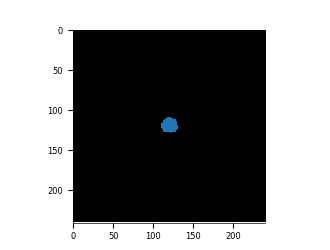

/tmp/ipykernel_18977/2601480546.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  real_PSF = real_PSF[int(df["mass_center_z"])]


In [102]:
real_PSF = tifffile.imread("../../PSF_comparison/average_100x_PSF_postmag.tif").astype(np.float32)
label_image = cle.voronoi_otsu_labeling(real_PSF)
imshow(label_image, labels=True)
stats = cle.statistics_of_labelled_pixels(real_PSF, label_image)

df = pd.DataFrame(stats)
df[["mass_center_x", "mass_center_y", "mass_center_z"]]
pix_mic_conv = 0.05
real_PSF = real_PSF[int(df["mass_center_z"])]
real_PSF = rescale(real_PSF, (0.0655/1.5) / pix_mic_conv  , anti_aliasing=True)



real_PSF -= np.round(np.sort(real_PSF.flatten())[0:int(len(real_PSF.flatten())*.05)].mean()).astype(np.uint)
real_PSF -= real_PSF.min()
real_PSF = real_PSF / np.sum(real_PSF)


In [105]:
from scipy.optimize import curve_fit
from math import floor, log10
round_to_n = lambda x, n: round(x, -int(floor(log10(x))) + (n - 1))

In [106]:
def plot_fit(data_fitted, title):
    
    # Calculate the centerline indices
    center_x = int(real_PSF.shape[1] // 2)
    center_y = int(real_PSF.shape[0] // 2)
    
    # Extract the centerline profiles
    centerline_x_original = real_PSF[center_y, :]
    centerline_y_original = real_PSF[:, center_x]
    centerline_x_fitted = data_fitted[center_y, :]
    centerline_y_fitted = data_fitted[:, center_x]
    
    # Plot the centerline profiles
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    # Centerline along x-axis
    axes.plot(centerline_x_original/centerline_x_original.max(), label='Original', linestyle='--')
    axes.plot(centerline_x_fitted/centerline_x_fitted.max(), label='Fitted', linestyle='-')
    #axes.set_title('Centerline Profile along X-axis')
    axes.set_xlabel('Pixel Index')
    axes.set_ylabel('Intensity')
    axes.legend()
    axes.set_yscale("log")
    plt.xlabel("Distance (pixels)")
    plt.ylabel("Intensity (AU)")

    #MSE = (log_mse(centerline_x_original, centerline_x_fitted) + log_mse(centerline_y_original, centerline_y_fitted))/2
    MSE = mean_squared_error(real_PSF, data_fitted)
    plt.suptitle(f"{title}, MSE = {round_to_n(MSE,2)}", size=6)
    fig.subplots_adjust(left=0.3,bottom=0.3)
    plt.savefig(f"{title}.svg")
    plt.show()


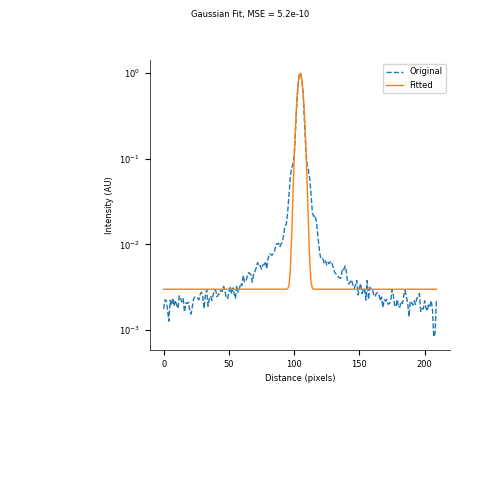

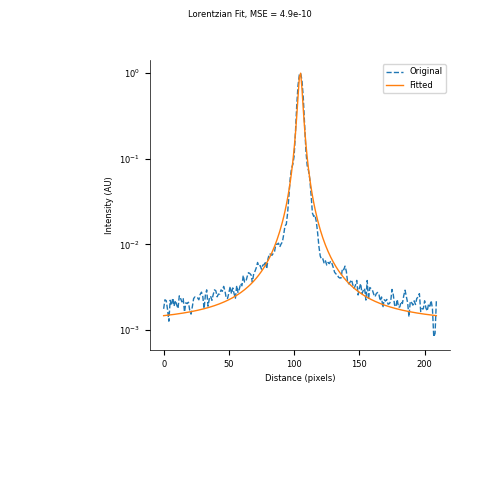

/tmp/ipykernel_18977/3516199931.py:45: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_lorentzian_DoG, _ = curve_fit(lorentzian_2d_DoG, (x, y), (real_PSF.ravel()), p0=initial_guess)


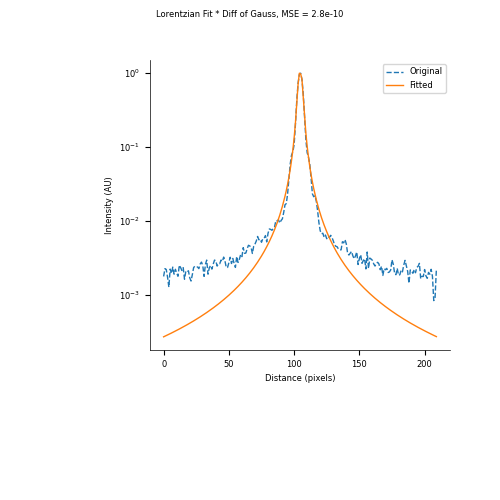

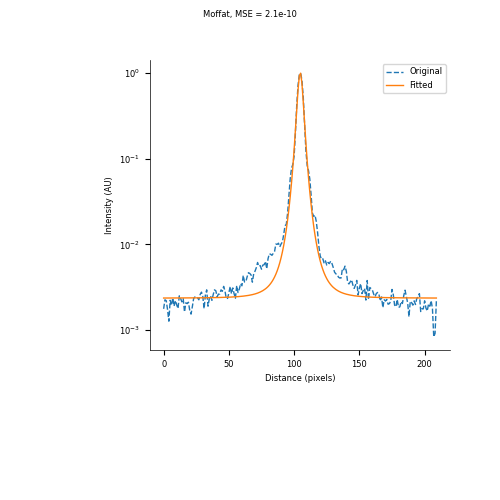

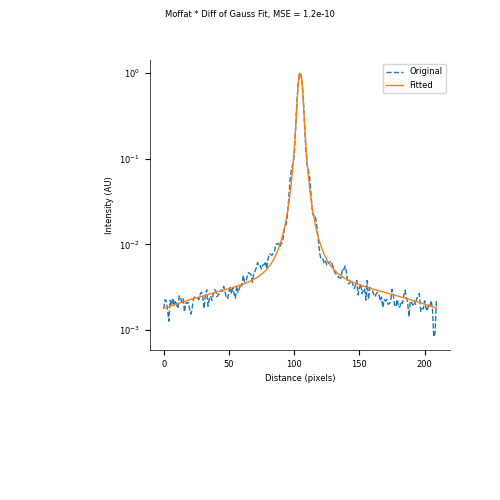

In [107]:
x = np.linspace(0, real_PSF.shape[1]-1, real_PSF.shape[1])
y = np.linspace(0, real_PSF.shape[0]-1, real_PSF.shape[0])
x, y = np.meshgrid(x, y)
initial_guess = (1, real_PSF.shape[0]/2, real_PSF.shape[1]/2, 1, 1, 0, 0)

popt, _ = curve_fit(gaussian_2d, (x, y), real_PSF.ravel(), p0=initial_guess)

data_fitted = gaussian_2d((x, y), *popt)
data_fitted = data_fitted.reshape(real_PSF.shape[0], real_PSF.shape[1])


plot_fit(data_fitted, "Gaussian Fit")


    
x = np.linspace(0, real_PSF.shape[1]-1, real_PSF.shape[1])
y = np.linspace(0, real_PSF.shape[0]-1, real_PSF.shape[0])
x, y = np.meshgrid(x, y)
    
# Initial guess parameters [amplitude, xo, yo, gamma_x, gamma_y, offset]
initial_guess = (1, real_PSF.shape[1]/2, real_PSF.shape[0]/2, 1, 1, 0)

# Fit the 2D Lorentzian
popt, _ = curve_fit(lorentzian_2d, (x, y), real_PSF.ravel(), p0=initial_guess)

# Generate data from the optimal parameters
data_fitted = lorentzian_2d((x, y), *popt)

# Reshape fitted data to 2D array
data_fitted = data_fitted.reshape(real_PSF.shape[0], real_PSF.shape[1])

plot_fit(data_fitted, "Lorentzian Fit")



    
x = np.linspace(0, real_PSF.shape[1]-1, real_PSF.shape[1])
y = np.linspace(0, real_PSF.shape[0]-1, real_PSF.shape[0])
x, y = np.meshgrid(x, y)
    
# Initial guess parameters [amplitude, xo, yo, gamma_x, gamma_y, offset]
initial_guess = (1, real_PSF.shape[1]/2, real_PSF.shape[0]/2, 1, 1, 1, 2, 0)

# Fit the 2D Lorentzian
popt_lorentzian_DoG, _ = curve_fit(lorentzian_2d_DoG, (x, y), (real_PSF.ravel()), p0=initial_guess)

# Generate data from the optimal parameters
data_fitted = lorentzian_2d_DoG((x, y), *popt_lorentzian_DoG)

# Reshape fitted data to 2D array
data_fitted = data_fitted.reshape(real_PSF.shape[0], real_PSF.shape[1])
plot_fit(data_fitted, "Lorentzian Fit * Diff of Gauss")




x = np.linspace(0, real_PSF.shape[1]-1, real_PSF.shape[1])
y = np.linspace(0, real_PSF.shape[0]-1, real_PSF.shape[0])
x, y = np.meshgrid(x, y)
    
# Initial guess parameters [amplitude, xo, yo, alpha_x, alpha_y, beta, offset]
initial_guess = (1, real_PSF.shape[1]/2, real_PSF.shape[0]/2, 1, 1, 1, 0)

# Fit the 2D Asymmetric Moffat
popt, _ = curve_fit(asymmetric_moffat_2d, (x, y), real_PSF.ravel(), p0=initial_guess)

# Generate data from the optimal parameters
data_fitted = asymmetric_moffat_2d((x, y), *popt)

# Reshape fitted data to 2D array
data_fitted = data_fitted.reshape(real_PSF.shape[0], real_PSF.shape[1])

plot_fit(data_fitted, "Moffat")





x = np.linspace(0, real_PSF.shape[1]-1, real_PSF.shape[1])
y = np.linspace(0, real_PSF.shape[0]-1, real_PSF.shape[0])
x, y = np.meshgrid(x, y)
    
# Initial guess parameters [amplitude, xo, yo, alpha_x, alpha_y, beta, offset]
initial_guess = (0.4, real_PSF.shape[1]/2, real_PSF.shape[0]/2, 1, 1, 1, 0, 3, 1)

# Fit the 2D Asymmetric Moffat
popt, _ = curve_fit(asymmetric_moffat_DoG, (x, y), (real_PSF.ravel()), p0=initial_guess)

# Generate data from the optimal parameters
data_fitted = asymmetric_moffat_DoG((x, y), *popt)

# Reshape fitted data to 2D array
data_fitted = data_fitted.reshape(real_PSF.shape[0], real_PSF.shape[1])

plot_fit(data_fitted, "Moffat * Diff of Gauss Fit")



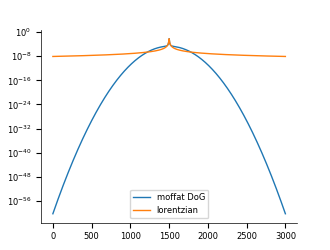

In [111]:
extrapolation_size = 3000
x = np.linspace(0, extrapolation_size, extrapolation_size)
y = np.linspace(0, extrapolation_size, extrapolation_size)
x, y = np.meshgrid(x, y)
    
# Initial guess parameters [amplitude, xo, yo, alpha_x, alpha_y, beta, offset]

# Fit the 2D Asymmetric Moffat
popt[1] = extrapolation_size/2
popt[2] = extrapolation_size/2
# Generate data from the optimal parameters
data_fitted = asymmetric_moffat_DoG((x, y), *popt)
# Reshape fitted data to 2D array
data_fitted = data_fitted.reshape(extrapolation_size, extrapolation_size)
data_fitted[data_fitted.shape[0]//2, data_fitted.shape[1]//2] = data_fitted.max()
plt.plot(data_fitted[data_fitted.shape[0]//2], label = "moffat DoG")

# Fit the 2D Asymmetric Moffat
popt_lorentzian_DoG[1] = extrapolation_size/2
popt_lorentzian_DoG[2] = extrapolation_size/2
# Generate data from the optimal parameters
data_fitted = lorentzian_2d_DoG((x, y), *popt_lorentzian_DoG)
# Reshape fitted data to 2D array
data_fitted = data_fitted.reshape(extrapolation_size, extrapolation_size)
data_fitted[data_fitted.shape[0]//2, data_fitted.shape[1]//2] = data_fitted.max()
plt.plot(data_fitted[data_fitted.shape[0]//2], label = "lorentzian")
plt.legend()
plt.yscale("log")


In [109]:
asymmetric_moffat_DoG

<function __main__.asymmetric_moffat_DoG(xdata_tuple, amplitude, xo, yo, alpha_x, alpha_y, beta, offset, sigma1, sigma2)>

In [89]:
popt

array([1.94750259e-01, 5.00000000e+02, 5.00000000e+02, 4.81577236e-01,
       4.84800012e-01, 1.20572644e+00, 2.14840436e-05, 9.37090468e+01,
       1.32972095e+00])

In [81]:
9.37090468e+01

93.7090468

In [82]:
 1.32972095e+00

1.32972095

In [83]:
lorentzian_2d_DoG

<function __main__.lorentzian_2d_DoG(xdata_tuple, amplitude, xo, yo, gamma_x, gamma_y, sigma1, sigma2, offset)>

In [84]:
1.02742617e+00

1.02742617

In [85]:
 8.96442134e+04

89644.2134

In [86]:
popt_lorentzian_DoG

array([8.30218211e-03, 5.00000000e+02, 5.00000000e+02, 1.68594280e+00,
       1.67212605e+00, 1.00000000e+00, 2.00000000e+00, 8.51748613e-06])

size: 104


/tmp/ipykernel_17758/359588671.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  real_PSF = real_PSF[int(df["mass_center_z"])]


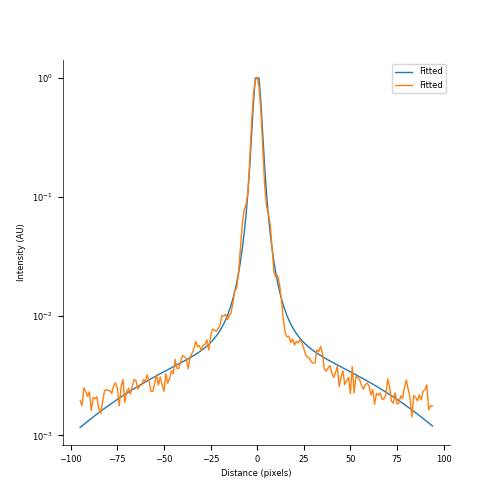

size: 104


/tmp/ipykernel_17758/359588671.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  real_PSF = real_PSF[int(df["mass_center_z"])]


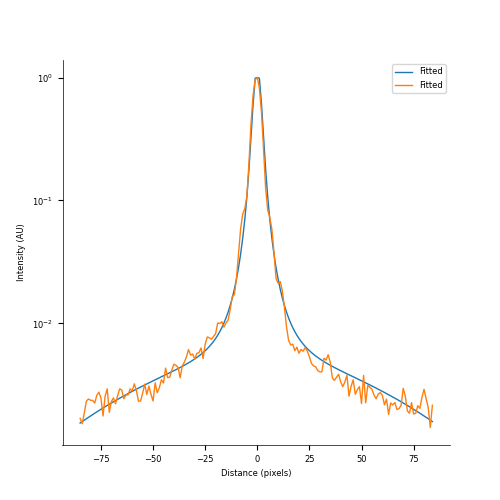

size: 104


/tmp/ipykernel_17758/359588671.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  real_PSF = real_PSF[int(df["mass_center_z"])]


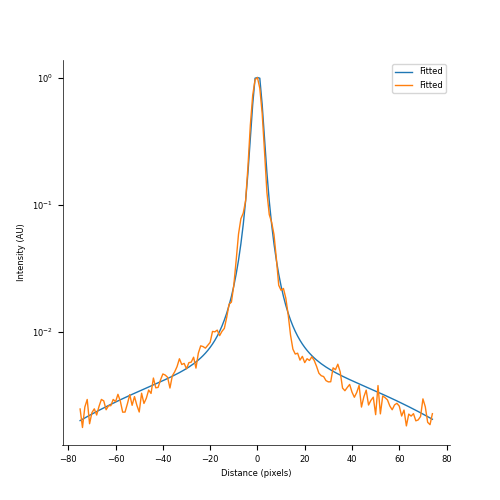

size: 104


/tmp/ipykernel_17758/359588671.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  real_PSF = real_PSF[int(df["mass_center_z"])]


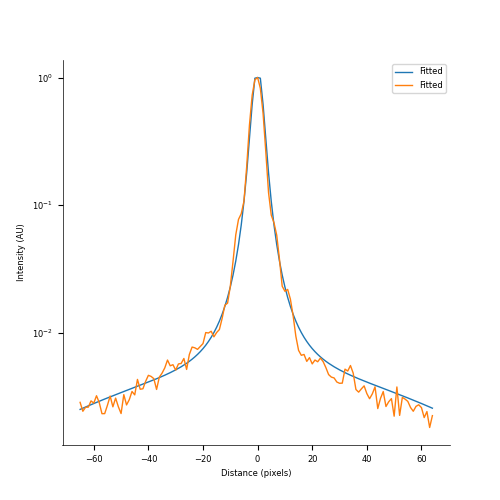

size: 104


/tmp/ipykernel_17758/359588671.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  real_PSF = real_PSF[int(df["mass_center_z"])]


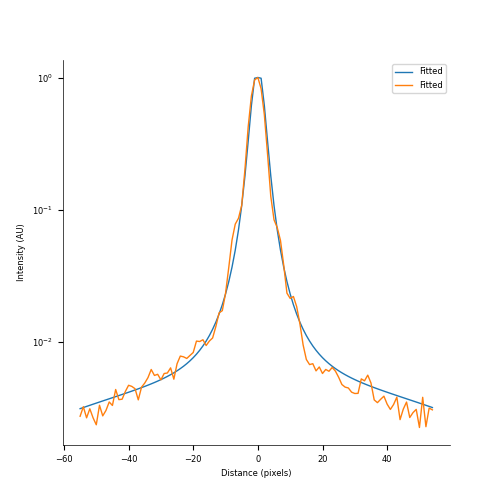

size: 104


/tmp/ipykernel_17758/359588671.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  real_PSF = real_PSF[int(df["mass_center_z"])]


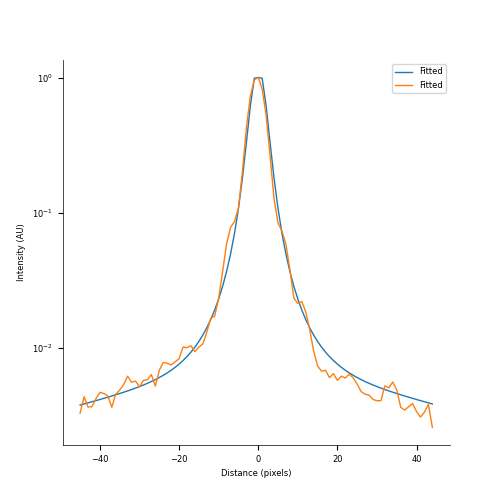

size: 104


/tmp/ipykernel_17758/359588671.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  real_PSF = real_PSF[int(df["mass_center_z"])]


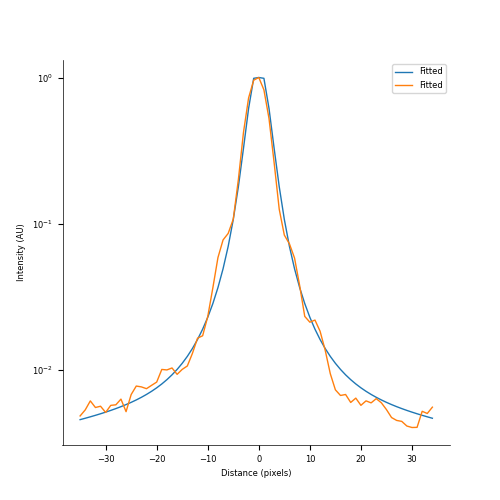

size: 104


/tmp/ipykernel_17758/359588671.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  real_PSF = real_PSF[int(df["mass_center_z"])]


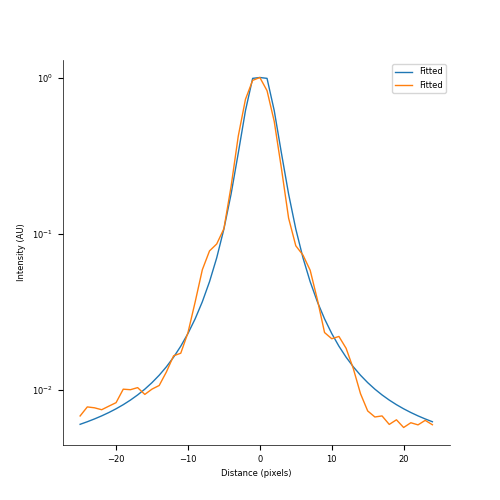

size: 104


/tmp/ipykernel_17758/359588671.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  real_PSF = real_PSF[int(df["mass_center_z"])]


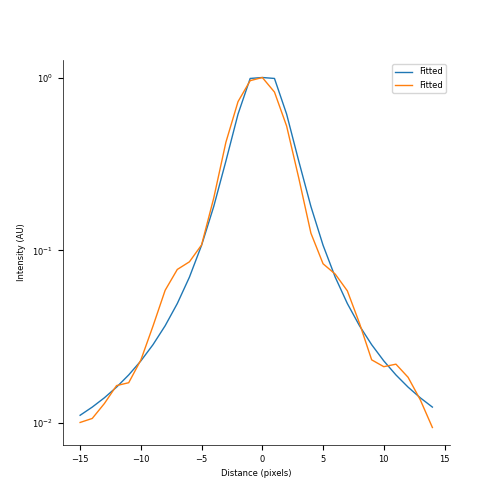

size: 104


/tmp/ipykernel_17758/359588671.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  real_PSF = real_PSF[int(df["mass_center_z"])]


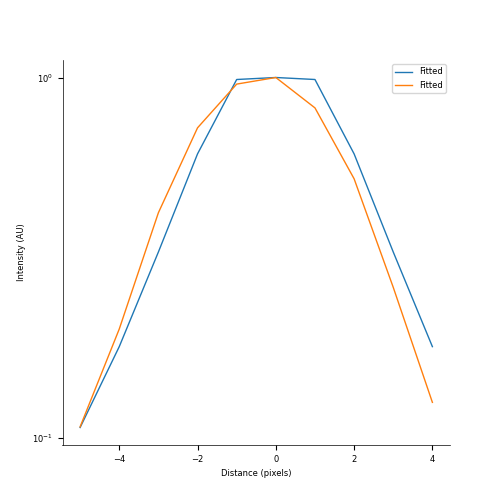

In [210]:

for PSF_size in [ 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))

    real_PSF = tifffile.imread("../../PSF_comparison/average_100x_PSF_postmag.tif").astype(np.float32)
    label_image = cle.voronoi_otsu_labeling(real_PSF)
    #imshow(label_image, labels=True)
    stats = cle.statistics_of_labelled_pixels(real_PSF, label_image)
    
    df = pd.DataFrame(stats)
    df[["mass_center_x", "mass_center_y", "mass_center_z"]]
    pix_mic_conv = 0.05
    real_PSF = real_PSF[int(df["mass_center_z"])]
    real_PSF = rescale(real_PSF, (0.0655/1.5) / pix_mic_conv  , anti_aliasing=True)
    
    
    
    
    real_PSF -= np.round(np.sort(real_PSF.flatten())[0:int(len(real_PSF.flatten())*.05)].mean()).astype(np.uint)
    real_PSF -= real_PSF.min()
    real_PSF = real_PSF / np.sum(real_PSF)
    
    real_PSF = real_PSF[PSF_size:-PSF_size,PSF_size:-PSF_size]

    


        # Calculate the centerline indices
    center_x = int(real_PSF.shape[1] // 2)
    center_y = int(real_PSF.shape[0] // 2)
    
    # Extract the centerline profiles
    centerline_x_original = real_PSF[center_y, :]
    centerline_y_original = real_PSF[:, center_x]
    centerline_x_fitted = data_fitted[center_y, :]
    centerline_y_fitted = data_fitted[:, center_x]
    
    # Plot the centerline profiles
    # Centerline along x-axis
    axes.plot(np.arange(-len(centerline_x_fitted)/2,len(centerline_x_fitted)/2), centerline_x_fitted/centerline_x_fitted.max(), label='Fitted', linestyle='-')
    axes.plot(np.arange(-len(centerline_x_fitted)/2,len(centerline_x_fitted)/2), centerline_x_original/centerline_x_original.max(), label='Fitted', linestyle='-')

    #axes.set_title('Centerline Profile along X-axis')
    axes.set_xlabel('Pixel Index')
    axes.set_ylabel('Intensity')
    axes.legend()
    axes.set_yscale("log")
    plt.xlabel("Distance (pixels)")
    plt.ylabel("Intensity (AU)")
    plt.show()